# Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import zipfile
import shutil
import urllib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
import scipy.stats as sp
import statsmodels.api as sm

from datetime import datetime
from bs4 import BeautifulSoup
from pylab import rcParams
import platform
rcParams['figure.figsize'] = 15, 10
import re
import os
import sys
import glob
import folium

import matplotlib
import pyproj
from pyproj import Proj

import gzip

import cx_Oracle

import ftplib
import calendar
import datetime
from datetime import date




C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import qgrid
qgrid.nbinstall(overwrite=True) 

In [3]:
import wellapplication as wa

In [4]:
import arcpy
from arcgis.gis import GIS
import json
import arcgis

In [5]:
print("Operating System {:} {:}".format(platform.system(),platform.release()))
print("Python Version {:}".format(sys.version))
print("Pandas Version {:}".format(pd.__version__))
print("Numpy Version {:}".format(np.__version__))
print("Matplotlib Version {:}".format(matplotlib.__version__))
print("Wellapplication Version {:}".format(wa.__version__))

Operating System Windows 7
Python Version 3.5.3 |Continuum Analytics, Inc.| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]
Pandas Version 0.20.1
Numpy Version 1.11.2
Matplotlib Version 1.5.3
Wellapplication Version 0.4.28


In [6]:
connection_filepath = "E:\Google Drive\WORK\Groundwater Chemistry"
sys.path.append(connection_filepath)
import oraconnection
import gisconnection

In [7]:
connection = oraconnection.oraconnect()

In [8]:
gis = gisconnection.get_gis()

# Directories

In [9]:
if platform.system() == 'Windows':
    if platform.system() + " " + platform.release() == 'Windows 7':
        drive = 'E:/Google Drive/WORK/'
    else:
        drive = 'M:/PROJECTS/'
else:
    drive = '/media/pi/Transcend/PROJECTS/'
    
#fileplace =  drive + '/PROJECTS/Round_Valley/'

#fileLocation = fileplace + 'URVH/URVH/'

fileplace = drive + 'Round_Valley/Data/Chemistry/'
figplace = drive + 'Round_Valley/Writing/Figures/'
shpplace = drive + 'Round_Valley/Data/GIS/'

# Import Functions

In [10]:
def df2PntShp(df,x,y,plc,espg):
    import shapefile
    import urllib
    # https://glenbambrick.com/2016/01/24/reproject-shapefile/

    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType=typeDict[df[col].dtype.name])
    for i in list(df.index):
        w.point(df.ix[i,x], df.ix[i,y])
        w.record(*list(df.ix[i,:].values))

    w.save(str(plc))

    prj = open(plc + ".prj", "w")
    wkt = urllib.urlopen("http://spatialreference.org/ref/epsg/{0}/prettywkt/".format(epsg))
    remove_spaces = wkt.read().replace(" ","")
    proESPG = remove_spaces.replace("\n", "")
    prj.write(proESPG)
    prj.close()
    print("file saved at {}".format(plc))
    
def df2PntShpAP(df,x,y,plc,epsg):
    import shapefile
    
    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType = typeDict[df[col].dtype.name])

    for i in df.index:
        w.point(df.loc[i,x], df.loc[i,y])
        w.record(*list(df.loc[i,:].values))

    w.save(str(plc))
    sr = arcpy.SpatialReference(epsg) #NAD83 zone 12
    arcpy.DefineProjection_management(plc+'.shp', sr)
    
    

def df2PntFt(df,x,y,shpplace,shpname,gdb,epsg):
    '''
    input is Pandas Dataframe
    df = dataframe to input
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    '''
    import arcpy
    arcpy.env.overwriteOutput = True
    df2PntShpAP(df,x,y,shpplace+shpname,epsg)
    arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpname +'.shp', shpplace+gdb, shpname)
    print("file saved at {}".format(shpplace+gdb+"/"+shpname))
    
def xl2PntFt(xlfile,x,y,shpplace,shpname,gdb,epsg,sheetname='Sheet1'):
    '''
    Converts excel file into shapefile and feature class.  
    Input should be excel file that has 1 row of column headers on the first row of the spreadsheet.
    Output is a point feature class, a shapefile, and Pandas dataframe of the data
    
    xlfile = string of file and diretory (include extension)
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    sheetname = optional; name of sheet in excel file where data are stored
    '''
    df = pd.read_excel(xlfile,sheetname)
    df2PntFt(df,x,y,shpplace,shpname,gdb,epsg)
    return df

def reind_inc(df):
    df['increment'] = range(0,len(df))
    df = df.reset_index(['increment'])
    return df


def df_to_published_data(df,title):

    df.rename(columns={'Lat_Y':'y','Lon_X':'x'},inplace=True)
    fc = gis.content.import_data(df)
    map1 = gis.map(location= [df.x.mean(),df.y.mean()], zoomlevel=12)
    map1.add_layer(fc)#,{"renderer":"ClassedSizeRenderer","field_name": "TDS"})
    xmin = round(df.x.min()-0.1,2)
    ymin = round(df.y.min()-0.1,2)
    xmax = round(df.x.max()+0.1,2)
    ymax = round(df.y.max()+0.1,2)

    item_properties = {
        "title": title,
        "tags" : "utah, groundwater,water quality",
        "snippet": "Round Valley Water Quality",
        "description": "samples collected by UGS",
        "text": json.dumps({"featureCollection": {"layers": [dict(fc.layer)]}}),
        "type": "Feature Collection",
        "typeKeywords": "Data, Feature Collection, Singlelayer",
        "extent" : "{:},{:},{:},{:}".format(xmin,ymin,xmax,ymax)
    }

    item = gis.content.add(item_properties)
    return item, map1

# WQP Data

In [11]:
wq = wa.WQP('-111.54,40.28,-111.29,40.48','bBox',siteType = ['Well','Spring','Subsurface','Stream'], 
            characteristicType = ['Inorganics, Major, Non-metals', 'Inorganics, Major, Metals','Information',
                                  'Inorganics, Minor, Metals', 'Inorganics, Minor, Non-metals',
                                  'Nutrient','Physical'])
wq.results.to_pickle(fileplace + 'raw_results.pickle')
wq.stations.to_pickle(fileplace + 'raw_stations.pickle')

https://www.waterqualitydata.us/Result/search?characteristicType=Inorganics%2C+Major%2C+Non-metals&characteristicType=Inorganics%2C+Major%2C+Metals&characteristicType=Information&characteristicType=Inorganics%2C+Minor%2C+Metals&characteristicType=Inorganics%2C+Minor%2C+Non-metals&characteristicType=Nutrient&characteristicType=Physical&mimeType=csv&sorted=no&siteType=Well&siteType=Spring&siteType=Subsurface&siteType=Stream&bBox=-111.54%2C40.28%2C-111.29%2C40.48&zip=no


In [12]:
rv_gw_results = wq.massage_results()
rv_gw_stations = wq.massage_stations()

In [13]:
rv_gw_stations['huc12'] = rv_gw_stations[['Lon_X', u'Lat_Y']].apply(lambda x: wa.get_huc(x)[0],1)
rv_gw_stations['huc12_name'] = rv_gw_stations[['Lon_X', u'Lat_Y']].apply(lambda x: wa.get_huc(x)[1],1)

In [14]:
rv_gw_stations = rv_gw_stations[rv_gw_stations['huc12'].isin(['160202030403','160202030402','160202030404'])]
rv_gw_results = rv_gw_results[rv_gw_results['StationId'].isin(rv_gw_stations['StationId'].values)]

In [15]:
rv = pd.merge(rv_gw_stations, rv_gw_results, on = 'StationId')

In [16]:
rv_gw_results.columns

Index(['OrgId', 'OrgName', 'SampleId', 'SampType', 'SampMedia', 'SampleDate',
       'SampDepth', 'SampDepthU', 'SampDepthRef', 'ProjectId', 'StationId',
       'SampComment', 'SampMeth', 'SampMethName', 'SampEquip', 'DetectCond',
       'Param', 'SampFrac', 'ResultValue', 'Unit', 'QualCode', 'ResultStatus',
       'ResultComment', 'USGSPCode', 'AnalytMeth', 'AnalytMethId',
       'MethodDescript', 'LabName', 'AnalysisDate', 'LabComments', 'LimitType',
       'MDL', 'MDLUnit'],
      dtype='object')

In [17]:
matchdict = {'Specific conductance':'Cond', 'Calcium':'Ca', 'Bicarbonate':'HCO3','Arsenic':'As','Barium':'Ba','Boron':'B',
             'pH':'pH', 'Total suspended solids':'TSS', 'Sulfate':'SO4', 'Turbidity':'Turb','Stream flow, mean. daily':'Q',
             'Inorganic nitrogen (nitrate and nitrite)':'NO3+NO2-N', 'Carbonate':'CO3', 'Ammonium':'NH4',
             'Phosphate':'PO4', 'Chloride':'Cl', 'Carbon dioxide':'CO2', 'Magnesium':'Mg', 'Potassium':'K',
             'Sodium':'Na', 'Total dissolved solids':'TDS','Dissolved oxygen (DO)':'DO', 'Flow':'Q', 
             'Temperature, water':'Temp','Calcium carbonate':'CaCO3', 'Alkalinity, total':'Alk',
             'Nitrogen':'N', 'Nitrate':'NO3', 'Orthophosphate':'PO4', 'Nitrite':'NO2',
             'Fluoride':'F', 'Silica':'Si', 'Ammonia':'NH4','Sodium plus potassium':'NaK',
             'Copper':'Cu','Iron':'Fe','Silver':'Ag','Manganese':'Mn','Nickel':'Ni','Lead':'Pb'}
rv_gw_results['ParAbb'] = rv_gw_results['Param'].apply(lambda x: matchdict.get(x),1)
rv_gw_results.drop_duplicates(subset=['SampleId','ParAbb'],inplace=True)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
piv_gw = rv_gw_results.pivot(index='SampleId',columns='ParAbb',values='ResultValue')
piv_gw.reset_index(inplace=True)

In [38]:
rv_matchIDS = rv_gw_results[['StationId','SampleId']].drop_duplicates().set_index('SampleId').to_dict()['StationId']
sampdatedict = rv_gw_results[['SampleId','SampleDate']].set_index('SampleId').to_dict()['SampleDate']

piv_gw['SampleDate'] = piv_gw['SampleId'].apply(lambda x: sampdatedict.get(x), 1)
piv_gw['StationId'] = piv_gw.SampleId.apply(lambda x: rv_matchIDS.get(x),1)
piv_gw2 = pd.merge(piv_gw, rv_gw_stations, on='StationId', how='outer')
piv_gw2.drop_duplicates(inplace=True)
piv_gw2['StationType'].unique()

array(['Stream', 'Well', 'Spring'], dtype=object)

0.988677954293


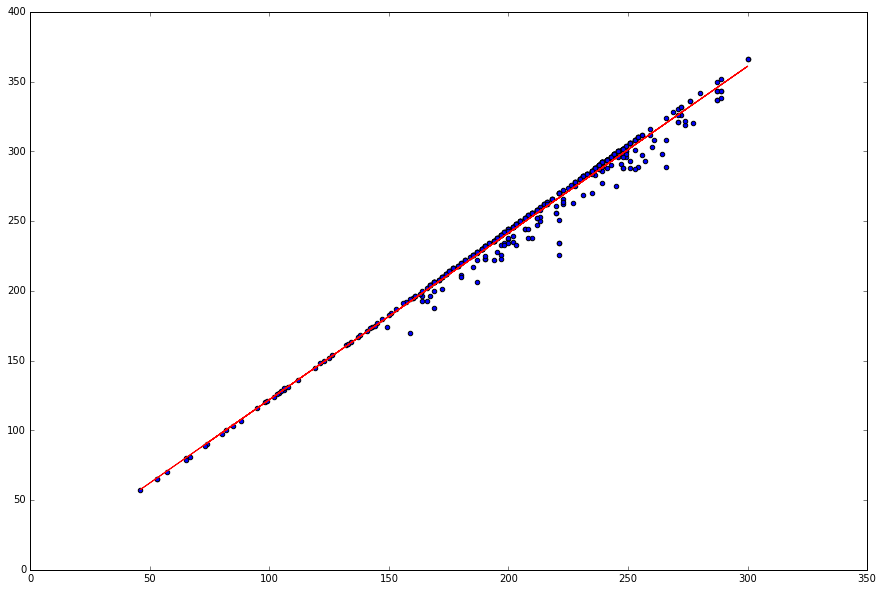

In [39]:
alkrelate = piv_gw2.dropna(subset=['HCO3','Alk'])
alkrelate
plt.scatter(alkrelate['Alk'],alkrelate['HCO3'])
x = alkrelate['Alk']; y = alkrelate['HCO3']

slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
plt.plot(x,[i*slope+intercept for i in x],color='red')
print(r_value**2)

for ind in piv_gw2.index:
    if pd.isnull(piv_gw2.loc[ind,'HCO3']) and pd.notnull(piv_gw2.loc[ind,'Alk']):
        piv_gw2.loc[ind,'HCO3'] = piv_gw2.loc[ind,'Alk']*slope + intercept
        
pippiv = piv_gw2.dropna(subset=['Ca','Na','SO4','Cl','Mg','HCO3'])
gwpippiv = pippiv[pippiv['StationType'].isin(['Well','Spring'])]

In [40]:
piv_gw2 = piv_gw2[['SampleId', 'Alk', 'CO2', 'CO3', 'Ca', 'CaCO3', 'Cl', 
                 'Cond', 'DO', 'F', 'HCO3', 'K', 'Mg', 'N', 'NH4', 'NO2', 
                 'NO3', 'NO3+NO2-N', 'Na', 'NaK', 'PO4', 'Q', 'SO4', 'Si', 
                 'TDS', 'TSS', 'Temp', 'pH', 'StationId', 'OrgId', 'SampleDate',
                 'OrgName', 'StationName', 'StationType', 'StationComment', 
                 'Lat_Y', 'Lon_X', 'Elev', 'Aquifer', 'FmType', 'AquiferType', 
                 'ConstDate', 'Depth', 'DepthUnit', 'HoleDepth', 'HoleDUnit']]

In [41]:
rv_gw_results.to_pickle(fileplace + 'wqp_gw_results.pickle')
piv_gw2.to_pickle(fileplace+'wqp_gw_res_piv.pickle')
rv_gw_stations.to_pickle(fileplace + 'wqp_gw_stations.pickle')

In [42]:
wqp_stations = pd.read_pickle(fileplace + 'wqp_gw_stations.pickle')
wqp_results = pd.read_pickle(fileplace + 'wqp_gw_results.pickle')
wqp_piv = pd.read_pickle(fileplace+'wqp_gw_res_piv.pickle')

In [43]:
wqp_piv.columns

Index(['SampleId', 'Alk', 'CO2', 'CO3', 'Ca', 'CaCO3', 'Cl', 'Cond', 'DO', 'F',
       'HCO3', 'K', 'Mg', 'N', 'NH4', 'NO2', 'NO3', 'NO3+NO2-N', 'Na', 'NaK',
       'PO4', 'Q', 'SO4', 'Si', 'TDS', 'TSS', 'Temp', 'pH', 'StationId',
       'OrgId', 'SampleDate', 'OrgName', 'StationName', 'StationType',
       'StationComment', 'Lat_Y', 'Lon_X', 'Elev', 'Aquifer', 'FmType',
       'AquiferType', 'ConstDate', 'Depth', 'DepthUnit', 'HoleDepth',
       'HoleDUnit'],
      dtype='object')

# AWQMS Data

In [52]:
awqmsFile = r'E:/Google Drive/WORK/Round_Valley/Data/Chemistry/awqms Standard Export 16007.xlsx'
awqms = pd.read_excel(awqmsFile,skiprows=1)

dropcols = []
for column in list(awqms.describe().columns):
    if awqms.describe().loc['count',column] == 0:
        dropcols.append(column)
        
awqms.drop(dropcols, axis=1, inplace=True)

awqms['SampleDate'] = awqms[["Activity Start Date","Activity Start Time"]].apply(lambda x: pd.to_datetime(str(x[0])[:11]+str(x[1])[-8:],
                                                                                                                  format='%Y-%m-%d %H:%M:%S',
                                                                                                                  errors='coerce'),1)

In [53]:
matchdict = {'Specific conductance':'Cond', 'Calcium':'Ca', 'Bicarbonate':'HCO3',
             'pH':'pH', 'Total suspended solids':'TSS', 'Sulfate':'SO4', 'Turbidity':'Turb',
             'Inorganic nitrogen (nitrate and nitrite)':'NO3+NO2-N', 'Carbonate':'CO3', 'Ammonium':'NH4',
             'Phosphate':'PO4', 'Chloride':'Cl', 'Carbon dioxide':'CO2', 'Magnesium':'Mg', 'Potassium':'K',
             'Sodium':'Na', 'Total dissolved solids':'TDS','Dissolved oxygen (DO)':'DO', 'Flow':'Q', 
             'Temperature, water':'Temp','Calcium carbonate':'CaCO3', 'Alkalinity, total':'Alk',
             'Nitrogen':'N', 'Nitrate':'NO3', 'Orthophosphate':'PO4', 'Nitrite':'NO2',
             'Fluoride':'F', 'Silica':'Si', 'Ammonia':'NH4','Sodium plus potassium':'NaK',
            'Arsenic':'As','Selenium':'Se','Barium':'Ba','Copper':'Cu','Zinc':'Zn','Boron':'B'}
awqms['ParAbb'] = awqms['Characteristic Name'].apply(lambda x: matchdict.get(x),1)
awqms.drop_duplicates(subset=['Activity ID','ParAbb'],inplace=True)

In [54]:
piv_awqms = awqms.pivot(index='Activity ID',columns='ParAbb',values='Result Value')
piv_awqms.reset_index(inplace=True)
awqms_abb = awqms[['Activity ID','Monitoring Location ID', 'Monitoring Location Name',
                   'Monitoring Location Type', 'Monitoring Location State', 'Organization ID',
                   'Monitoring Location Latitude', 'Monitoring Location Longitude']]
piv_awqms_merge = pd.merge(piv_awqms,awqms_abb,on='Activity ID' )
piv_awqms_merge.drop_duplicates(inplace=True)
piv_awqms_merge['Monitoring Location Type'] = piv_awqms_merge['Monitoring Location Type'].apply(lambda x: x.replace('River/Stream','Stream'),1)


renamer = {'Organization ID':'OrgName','Activity ID':'SampleId',
           'Monitoring Location Latitude':'Lat_Y', 
           'Monitoring Location Longitude':'Lon_X',
           'Monitoring Location Type':'StationType',
           'Monitoring Location Name':'StationName',
           'Monitoring Location ID':'StationId'}
piv_awqms_merge.rename(columns=renamer, inplace=True)

sampdatedict = awqms[['Activity ID','SampleDate']].set_index('Activity ID').to_dict()['SampleDate']
piv_awqms_merge['SampleDate'] = piv_awqms_merge['SampleId'].apply(lambda x: sampdatedict.get(x), 1)


In [55]:
piv_awqms_merge = piv_awqms_merge[['SampleId', 'Alk', 'CO2', 'CO3', 'Ca', 'CaCO3', 'As', 'Ba', 'Zn','Se',
                                   'Cl', 'Cond', 'DO', 'HCO3', 'K', 'Mg', 'N', 'NO3+NO2-N', 
                                   'Na', 'Q', 'SO4', 'TDS', 'TSS', 'Temp', 'pH', 'StationId','SampleDate', 
                                   'StationName', 'StationType', 'OrgName', 'Lat_Y', 'Lon_X']]

In [56]:
awqms.to_pickle(fileplace + 'awqms_results.pickle')
piv_awqms_merge.to_pickle(fileplace+'awqms_piv.pickle')

In [57]:
awqms = pd.read_pickle(fileplace + 'awqms_results.pickle')
piv_awqms_merge = pd.read_pickle(fileplace + 'awqms_piv.pickle')

# SDWIS Data

In [71]:
def sql_bbox(x, connection):
    """
    x = list of bbox coordinates; lat top, long left, lat bottom, long right
    returns stations, chemistry
    """
    
    SQLtext = """
    SELECT 
    UTV80.TINWSF.TINWSF_IS_NUMBER AS "StationId",
    UTV80.TINWSF.NAME AS "StationName",
    UTV80.TINWSF.TYPE_CODE AS "StationType",
    UTV80.TINWSYS.TINWSYS_IS_NUMBER AS "OrgID",
    UTV80.TINWSYS.NAME AS "OrgName",
    UTV80.TINLOC.LATITUDE_MEASURE AS "Lat_Y",
    UTV80.TINLOC.LONGITUDE_MEASURE AS "Lon_X",
    UTV80.TINLOC.SRC_MAP_SCALE_NUM AS "MapScale",
    UTV80.TINLOC.HORIZ_ACCURACY_MSR AS "HorAcc",
    UTV80.TINLOC.HZ_COLLECT_METH_CD AS "HorCollMeth",
    UTV80.TINLOC.HORIZ_REF_DATUM_CD AS "HorRef",
    UTV80.TINLOC.VERTICAL_MEASURE AS "Elev",
    UTV80.TINLOC.VERT_ACCURACY_MSR AS "ElevAcc",
    UTV80.TINLOC.VER_COL_METH_CD AS "ElevMeth",
    UTV80.TINLOC.VERT_REF_DATUM_CD AS "ElevRef",
    UTV80.TINWSF.ACTIVITY_DATE AS "ActDate",
    UTV80.TINWSF.ACTIVITY_STATUS_CD AS "ActStatus"

    FROM
    UTV80.TINWSF
    JOIN UTV80.TINWSYS ON  UTV80.TINWSF.TINWSYS_IS_NUMBER = UTV80.TINWSYS.TINWSYS_IS_NUMBER  
    JOIN UTV80.TINLOC ON  UTV80.TINWSF.TINWSF_IS_NUMBER = UTV80.TINLOC.TINWSF_IS_NUMBER 

    WHERE
    (UTV80.TINWSF.TYPE_CODE IN('WL','SP','IN')) -- Spring, well, or intake
    AND (UTV80.TINLOC.LATITUDE_MEASURE < {:})
    AND (UTV80.TINLOC.LONGITUDE_MEASURE > {:})
    AND(UTV80.TINLOC.LATITUDE_MEASURE > {:})
    AND (UTV80.TINLOC.LONGITUDE_MEASURE < {:})
    """
    SQL = SQLtext.format(x[0],x[1],x[2],x[3]) # 40.44, -111.51, 40.30, -111.35
    stations = pd.read_sql(SQL, con = connection)
    stations['StationName'] = stations['StationName'].apply(lambda x: str(x).strip().title(), 1)
    
    stlist = list(stations['StationId'].unique())
    stlist = [str(i) for i in stlist]
    SQLtext = """
    SELECT
    UTV80.TINWSF.TYPE_CODE AS "SampType", 
    UTV80.TINWSF.TINWSF_IS_NUMBER AS "StationId", 
    UTV80.TINWSYS.TINWSYS_IS_NUMBER AS "OrgID", 
    UTV80.TINWSYS.NAME AS "OrgName", 
    UTV80.TSASAMPL.TSASAMPL_IS_NUMBER AS "SampleId", 
    UTV80.TSASAMPL.COLLLECTION_END_DT AS "SampleDate", 
    UTV80.TSASAMPL.COLLCTN_END_TIME AS "SampleTime", 
    UTV80.TSAANLYT.NAME AS "Param", 
    UTV80.TSASAR.CONCENTRATION_MSR AS "result_va", 
    UTV80.TSASAR.UOM_CODE AS "Unit", 
    UTV80.TSASAR.ANALYSIS_START_DT AS "AnalysisDate", 
    UTV80.TSASAR.DETECTN_LIMIT_NUM AS "MDL", 
    UTV80.TSASAR.DETECTN_LIM_UOM_CD AS "MDLUnit", 
    UTV80.TSAANLYT.CAS_REGISTRY_NUM AS "CAS_Reg", 
    UTV80.TSASAR.TSASAR_IS_NUMBER AS "ID_NUM",
    UTV80.TSASAMPL.COMMENT_TEXT AS "SamplePointComment",
    UTV80.TSASMPPT.DESCRIPTION_TEXT AS "SamplePointDesc"

    FROM 
    UTV80.TINWSF -- Water System Facility (water source)
    JOIN UTV80.TINWSYS ON -- Water System (town or water provider)
    UTV80.TINWSF.TINWSYS_IS_NUMBER = UTV80.TINWSYS.TINWSYS_IS_NUMBER 
    JOIN UTV80.TSASMPPT ON  -- Sample point
    UTV80.TINWSF.TINWSF_IS_NUMBER = UTV80.TSASMPPT.TINWSF0IS_NUMBER
    JOIN UTV80.TSASAMPL ON -- Sample
    UTV80.TSASMPPT.TSASMPPT_IS_NUMBER = UTV80.TSASAMPL.TSASMPPT_IS_NUMBER  -- Sample Point
    JOIN UTV80.TSASAR ON -- Sample Result
    UTV80.TSASAMPL.TSASAMPL_IS_NUMBER = UTV80.TSASAR.TSASAMPL_IS_NUMBER   -- Sample Number
    JOIN UTV80.TSAANLYT ON -- Analyte
    UTV80.TSASAR.TSAANLYT_IS_NUMBER = UTV80.TSAANLYT.TSAANLYT_IS_NUMBER  -- Analyte Number

    WHERE (UTV80.TINWSF.TYPE_CODE IN('WL','SP','IN')) -- Spring or well or intake
    AND UTV80.TSASMPPT.SOURCE_TYPE_CODE = 'RW' -- Raw (unfiltered) water
    AND UTV80.TSASMPPT.TYPE_CODE IN('RW','EP','SR') -- From source
    AND UTV80.TINWSF.TINWSF_IS_NUMBER IN('{:}') 
    ORDER BY UTV80.TINWSF.ST_ASGN_IDENT_CD
    """
    
    SQL = SQLtext.format("','".join(stlist))
    chemistry = pd.read_sql(SQL, con = connection, parse_dates=['SampleDate','SampleTime','AnalysisDate'])
    chemistry['SampleDate'] = chemistry[["SampleDate", "SampleTime"]].apply(lambda x:pd.to_datetime(x[0],
                                                                                                    errors='ignore',
                                                                                                    format="%Y-%m-%d %H:%M"), 1)
    return stations, chemistry

In [72]:
def piv_chem(stations, chemistry):
    
    paramdict = {'nitrate-nitrite':'NO3+NO2-N', 'nitrate':'NO3', 'sulfate':'SO4',
             'nitrite':'NO2', 'turbidity':'turb', 'silver':'Ag',
             'barium':'Ba', 'fluoride':'F', 
             'potassium':'K', 'arsenic':'As', 'mercury':'Hg',
             'sodium':'Na', 'selenium':'Se', 'cadmium':'Cd',
             'copper, free':'Cu', 'zinc':'Zn', 'silica':'Si',
             'magnesium':'Mg', 'lead':'Pb', 'calcium':'Ca',
             'nitrogen-ammonia as (n)':'NH4-N', 'chloride':'Cl', 
             'iron':'Fe', 'manganese':'Mn', 'phosphate, total':'PO4', 
             'carbon dioxide':'CO2', 'bicarbonate as hco3':'HCO3', 
             'alkalinity, total':'Alk', 'tds':'TDS', 'hardness, carbonate':'Hard', 
             'conductivity @ 25 c umhos/cm':'Cond', 
             'hardness, total (as caco3)':'Hard','iron, dissolved':'Fe', 'ph':'pH',
             'alkalinity, carbonate':'Alk'}
    
    
    chemistry['Param'] = chemistry['Param'].apply(lambda x: str(x).strip().lower(),1)
    chemistry['ParAbb'] = chemistry['Param'].apply(lambda x: paramdict.get(x),1)
    chemistry.drop_duplicates(subset=['SampleId','ParAbb'],inplace=True)
    chem_piv = chemistry.pivot(index='SampleId',columns='ParAbb',values='result_va')
    chem_piv.reset_index(inplace=True)

    chem_dict = chemistry[['SampleId','StationId']].set_index('SampleId').to_dict()['StationId']
    chem_piv['StationId'] =chem_piv['SampleId'].apply(lambda x: chem_dict.get(x),1)
    chem_piv = pd.merge(chem_piv,stations,on='StationId')
    
    sampdatedict = chemistry[['SampleId','SampleDate']].set_index('SampleId').to_dict()['SampleDate']
    chem_piv['SampleDate'] = chem_piv['SampleId'].apply(lambda x: sampdatedict.get(x), 1)

    chem_piv_piper = chem_piv.dropna(subset=['Ca','Na','SO4','Cl','Mg','HCO3'])
    chem_piv_piper = chem_piv_piper[(chem_piv_piper['Na'] > 0)&(chem_piv_piper['SO4'] > 0)&(chem_piv_piper['Cl'] > 0)]
    chem_piv_piper = reind_inc(chem_piv_piper)
    return chem_piv, chem_piv_piper

In [73]:
sdwis_stations, sdwis_chemistry = sql_bbox([40.44, -111.6, 40.30, -111.35],connection)
sdwis_chem_piv, sdwis_chem_piv_piper = piv_chem(sdwis_stations, sdwis_chemistry)
#wa.piper(chem_piv_piper,type_col='',var_col='TDS')

In [74]:
sdwis_chem_piv

,SampleId,nan,Ag,Alk,As,Ba,CO2,Ca,Cd,Cl,...,HorAcc,HorCollMeth,HorRef,Elev,ElevAcc,ElevMeth,ElevRef,ActDate,ActStatus,SampleDate
0,212358,8.00,NaN,172.0,NaN,0.050,1.0,47.0,NaN,4.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-09-01
1,212359,NaN,NaN,155.0,NaN,0.040,NaN,5.0,NaN,5.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-08-28
2,212360,6.00,NaN,155.0,NaN,0.040,NaN,42.0,NaN,4.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-08-28
3,212361,7.00,NaN,154.0,NaN,0.040,NaN,42.0,NaN,2.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-08-28
4,212362,7.00,NaN,164.0,NaN,0.050,NaN,44.0,NaN,2.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-08-29
5,212363,NaN,NaN,167.0,NaN,NaN,4.0,45.0,4.0,3.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1986-07-21
6,212364,NaN,NaN,180.0,NaN,NaN,NaN,37.0,NaN,8.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1983-08-09
7,212365,NaN,NaN,162.0,NaN,50.000,NaN,50.0,NaN,1.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1980-09-23
8,212366,40.00,NaN,156.0,NaN,29.000,NaN,42.0,NaN,6.0,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1977-11-17
9,219667,NaN,NaN,157.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15.00,018,003,0.0,0.0,,,1977-06-01,I,1987-08-28


In [75]:
sdwis_chem_piv = sdwis_chem_piv[['SampleId', 'Ag', 'Alk', 'As', 'Ba', 'CO2', 'Ca', 'Cd', 'Cl', 
                         'Cond', 'Cu', 'F', 'Fe', 'HCO3', 'Hard', 'Hg', 'K', 'Mg', 'Mn', 
                         'NH4-N', 'NO2', 'NO3', 'NO3+NO2-N', 'Na', 'PO4', 'Pb', 'SO4', 'Se', 
                         'Si', 'TDS', 'Zn', 'pH', 'StationId', 'StationName', 'SampleDate',
                         'StationType', 'OrgID', 'OrgName', 'Lat_Y', 'Lon_X', 'Elev']]

In [76]:
sdwis_stations.to_pickle(fileplace + 'sdwis_stations.pickle')
sdwis_chemistry.to_pickle(fileplace + 'sdwis_results.pickle')
sdwis_chem_piv.to_pickle(fileplace+'sdwis_piv.pickle')

# UGS Data

In [77]:
chemdatadir = 'E:/Google Drive/WORK/Round_Valley/Data/Chemistry/'
chemdata = pd.read_table(chemdatadir+'UTGS_EDD_20170907.txt', error_bad_lines=False, memory_map=True)

# Pick Relevant Sites
chemdata = chemdata[chemdata['Sample Description'].isin(['402313111262601', '40224111251901', '402208111241401', '402023111244501', 
                                            '402136111234201','402131111231601', '402439111284601'])]

chempiv = chemdata.pivot(index='Sample Number', columns='Param Description', values='Result Value')
chem = pd.merge(chempiv, chemdata, left_index= True, right_on= 'Sample Number', how='outer')

droplist = ['Project Name', 'Cost Code', 'Agency Bill Code','Trip ID', 
            'Sample Received Date','Chain of Custody', 'Replicate Number', 
            'Test Number', 'Method Agency','Method ID', 'Method Description', 
            'Matrix Description', 'Problem Identifier', 'Dilution Factor', 
            'Batch Number', 'Analysis Date', 'Project Comment', 
            'Sample Comment', 'Test Comment', 'Result Comment']
chem.drop(droplist, inplace=True, axis=1)

rename_dict = {'Bicarbonate':'HCO3','Carbonate':'CO3','Chloride':'Cl',
               'Conductivity':'Cond','Sulfate':'SO4','Nitrate + Nitrite as Nitrogen':'NO3+NO3-N',
              'Silica':'Si','Total Dissolved Solids':'TDS'}

chem = chem.rename(columns = rename_dict)
chem = chem[['Sample Number','HCO3','Ca','NO3+NO3-N','Mg','Na','K','TDS','CO3','SO4','Cl','Cond','Sample Description', 'Sample Date']]
chem = chem.drop_duplicates()
chem = chem.groupby(['Sample Description','Sample Date']).sum()
chem.reset_index(inplace=True)
#ppr = wa.piper(chem, type_col='',var_col='TDS')

In [78]:
site_data_file = chemdatadir + 'Chem_n_Flow.csv'
ugs_sites = pd.read_csv(site_data_file)

In [79]:
ugs_sites =ugs_sites[pd.notnull(ugs_sites['state_lab_id'])]
ugs_sites['state_lab_id'] = ugs_sites['state_lab_id'].apply(lambda x: str(int(pd.to_numeric(x))),1)

In [80]:
chemsitesugs = pd.merge(ugs_sites,chem, left_on='UofU_lab_id', right_on='Sample Description', how='inner')
chemsitesugs.drop_duplicates(inplace=True)
chemsitesugs.drop('Cond',axis=1, inplace=True)
chemrename = {'Lat':'Lat_Y','Long':'Lon_X','Sample Description':'StationId','Type':'StationType','T_C':'Temp',
              'state_lab_id':'SampleId','cond':'Cond','Q_cfs':'Q','Sample Date':'SampleDate'}
chemsitesugs.rename(columns=chemrename,inplace=True)

In [81]:
chemsitesugs = chemsitesugs[['SampleId', 'StationType', 'Cond', 'Temp', 'ORP_mV', 'pH', 
                             'Q', 'Lat_Y', 'Lon_X', 'StationId', 'SampleDate', 
                             'HCO3', 'Ca', 'NO3+NO3-N', 'Mg', 'Na', 'K', 'TDS', 
                             'CO3', 'SO4', 'Cl']]

In [82]:
chemsitesugs

,SampleId,StationType,Cond,Temp,ORP_mV,pH,Q,Lat_Y,Lon_X,StationId,...,HCO3,Ca,NO3+NO3-N,Mg,Na,K,TDS,CO3,SO4,Cl
0,2015647,Well,352,17.0,223.0,8.18,NaN,40.360210,-111.395000,402136111234201,...,227.0,64.3,0.280,18.1,9.14,1.69,272.0,0.0,42.4,10.80
1,2015643,Well,332,12.7,216.0,7.47,NaN,40.386980,-111.440000,402313111262601,...,223.0,63.4,1.550,13.2,11.40,1.22,258.0,0.0,20.0,15.70
2,2015644,Well,304,14.2,204.0,7.91,NaN,40.370140,-111.423000,40224111251901,...,221.0,63.1,0.282,10.7,8.10,1.31,244.0,0.0,20.0,12.60
3,2015645,Well,316,14.8,237.0,7.46,NaN,40.368791,-111.404004,402208111241401,...,222.0,59.8,0.100,15.4,8.13,1.15,244.0,0.0,27.0,9.80
4,2015646,Stream,308,11.7,153.0,8.55,0.47,40.340102,-111.412319,402023111244501,...,241.0,68.2,0.430,11.0,5.06,1.00,240.0,0.0,20.0,6.61
5,2021165,Spring,615,16.0,177.0,7.44,NaN,40.410916,-111.479287,402439111284601,...,271.0,98.7,1.660,24.4,52.30,2.83,470.0,0.0,21.1,119.00
6,2021162,Well,327,12.1,152.0,7.74,NaN,40.358470,-111.388000,402131111231601,...,231.0,62.9,0.591,15.1,11.80,1.00,240.0,0.0,20.0,12.90


# Loughlin Data

Index(['Parameter', 'ParAbb', 'SampleDate', 'Result', 'MDL', 'Analaysis Date',
       'Method', 'StationType', 'Analyst', 'Units', 'System', 'Org',
       'StationName', 'SampleId', 'Lab', 'SampOrg', 'StationId', 'Lat_Y',
       'Lon_X'],
      dtype='object')

In [115]:
loughlin = pd.read_excel('E:/Google Drive/WORK/Round_Valley/Data/Chemistry/LoughlinChemData.xlsx')
loughlin.drop_duplicates(subset=['SampleId','ParAbb'],inplace=True)

def getmdl(x):
    if str(x[0])[0] == '<':
        return x[1]/2
    else:
        return x[0]

loughlin['Result'] = loughlin[['Result','MDL']].apply(lambda x: pd.to_numeric(getmdl(x)),1)

lough_piv = loughlin.pivot(index='SampleId',columns='ParAbb',values='Result')
lough_piv = lough_piv[['Ag', 'As', 'CO2', 'CO3', 'Ca', 'CaCO3', 'Cd', 
                       'Cl', 'Cond', 'Cr', 'Cu', 'Fe',  'HCO3', 'K', 'Mg',
                       'Mn', 'NO3-N', 'Na', 'Ni', 'OH', 'P', 'PO4-P', 'Pb',
                       'SO4', 'Sb', 'Se', 'TDS', 'Tl', 'Zn', 'pH']]

In [116]:
loughsub = loughlin[['SampleDate', 'StationType', 'System', 'Org',  'StationName', 'SampleId', 
                     'SampOrg', 'StationId', 'Lat_Y','Lon_X']]
lough_piv = pd.merge(lough_piv, loughsub, left_index=True, right_on='SampleId').drop_duplicates()

In [117]:
lough_piv

,Ag,As,CO2,CO3,Ca,CaCO3,Cd,Cl,Cond,Cr,...,SampleDate,StationType,System,Org,StationName,SampleId,SampOrg,StationId,Lat_Y,Lon_X
42,NaN,0.0008,142.0,0.5,52.2,156.0,NaN,20.0,379.0,NaN,...,2016-02-24 10:25:00,Well,NaN,NaN,Nelson Well,16B0911-01,Loughlin Water Associates,402216111251101,40.371212,-111.419703
21,NaN,0.0005,175.0,0.5,64.0,195.0,NaN,7.0,487.0,NaN,...,2016-06-08 10:00:00,Well,NaN,LDS Girls Camp,Camp Well,16F0459-01,Loughlin Water Associates,9290,40.334850,-111.378610
0,0.001,0.0025,NaN,NaN,58.7,NaN,0.0005,NaN,NaN,0.001,...,1996-03-20 19:00:00,Well,26009-02,Wallsburg,Town Well,96-U003257,Horrock Engineers,4916,40.382505,-111.420497


# Merge Data 

In [118]:
piv_chm = pd.concat([lough_piv, wqp_piv,sdwis_chem_piv,chemsitesugs,piv_awqms_merge],axis=0)

In [119]:
sttypes = {'SP':'Spring','WL':'Well','IN':'Stream'}
piv_chm['StationType'] = piv_chm['StationType'].apply(lambda x: sttypes.get(x,x),1)
piv_chm['StationType'].unique()

array(['Well', 'Stream', 'Spring'], dtype=object)

In [120]:
station_replace = {'6736':'402439111284601', '5913460':'UTAHDWQ-5913460', 
                   '5910619':'UTAHDWQ-5910619', '4996895':'UTAHDWQ-4996895',
                   '4996905':'UTAHDWQ-4996905','4996900':'UTAHDWQ-4996900',
                   '5910280':'USGS-402311111251401','5910283':'USGS-402311111251401',
                   'UTAHDWQ-5910280':'USGS-402311111251401',
                   'UTAHDWQ-5910283':'USGS-402311111251401',
                   'UTAHGS-402311111251401':'USGS-402311111251401',
                   '4996920':'UTAHDWQ-4996920',
                   '4996910':'UTAHDWQ-4996910'}
piv_chm['StationId'] = piv_chm['StationId'].apply(lambda x: station_replace.get(str(x),str(x)),1)

In [121]:
piv_chm

,Ag,Alk,Aquifer,AquiferType,As,Ba,CO2,CO3,Ca,CaCO3,...,StationId,StationName,StationType,System,TDS,TSS,Temp,Tl,Zn,pH
42,NaN,NaN,NaN,NaN,0.0008,NaN,142.0,0.5,52.2,156.0,...,402216111251101,Nelson Well,Well,NaN,216.0,NaN,NaN,NaN,NaN,6.50
21,NaN,NaN,NaN,NaN,0.0005,NaN,175.0,0.5,64.0,195.0,...,9290,Camp Well,Well,NaN,270.0,NaN,NaN,NaN,0.020,7.30
0,0.001,NaN,NaN,NaN,0.0025,NaN,NaN,NaN,58.7,NaN,...,4916,Town Well,Well,26009-02,NaN,NaN,NaN,0.0005,0.022,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,248.0,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,7.30
2,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,239.0,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,7.30
4,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,72.0,251.0,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,316.0,NaN,NaN,NaN,NaN,7.30
6,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN,...,UTAHDWQ-5913460,MAIN CK AB DEER CK RES AT US 189 XING,Stream,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plots

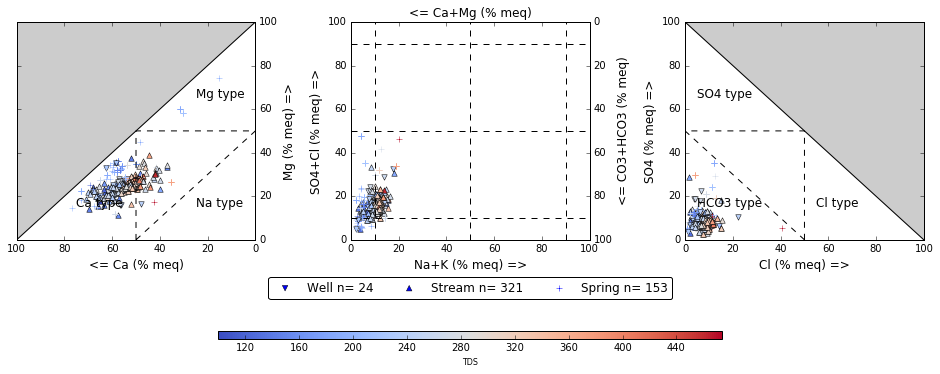

In [122]:
piv_piper = piv_chm.dropna(subset=['Ca','Na','SO4','Cl','Mg','HCO3'])
piv_piper = piv_piper[(piv_piper['Na'] > 0)&(piv_piper['SO4'] > 0)&(piv_piper['Cl'] > 0)]
piv_piper = reind_inc(piv_piper)
wa.piper(piv_piper,type_col='StationType',var_col='TDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'piper.pdf')

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


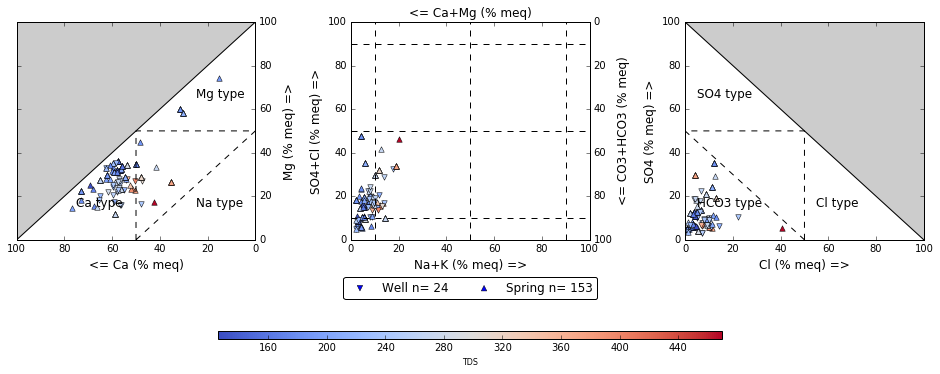

In [123]:
gw_piper = piv_piper[piv_piper['StationType'].isin(['Spring','Well'])]
gw_piper = reind_inc(gw_piper)
wa.piper(gw_piper,type_col='StationType',var_col='TDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'gw_piper.pdf')

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\frame.py:5945: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylim'

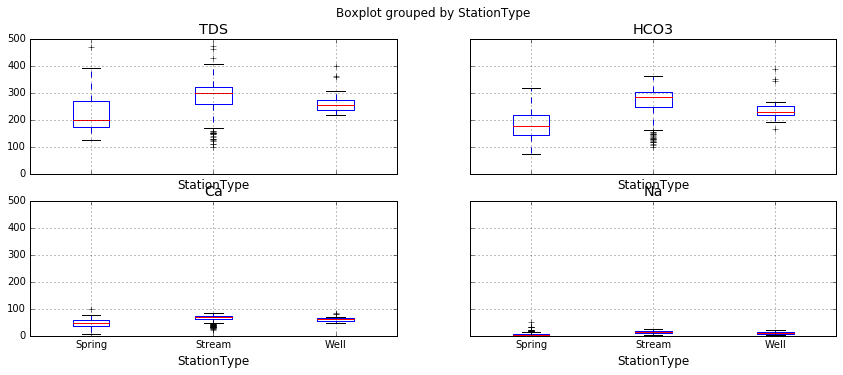

In [157]:

strcnt = {}
i=0

fig, [ax1,ax2,ax3,ax4] = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

piv_piper.boxplot(column=['TDS','HCO3'],ax = axes[0,:], by='StationType',return_type='axes')
piv_piper.boxplot(column=['Ca','Na'],ax = axes[1,:], by='StationType',return_type='axes')
piv_counts_prep = piv_piper.dropna(subset=['TDS'])[['StationType','StationId','SampleId']]
piv_counts = piv_counts_prep.groupby('StationType').nunique()[['StationId','SampleId']]

axes[1,:].set_ylim(1,100)
axes[0,:].set_ylim(1,1000)

for ind in piv_counts.index:
    for col in piv_counts.columns:
         strcnt[ind+"_"+col] = piv_counts.loc[ind,col]
    i += 1
    print(ind)
    sampcount = strcnt[ind+'_SampleId']
    statcount = strcnt[ind+'_StationId']
    #plt.text(i, 700, 
    #         "Sample Count = {:}\nStation Count = {:}".format(sampcount,statcount),
    #        horizontalalignment='center')
#plt.ylim(1,1000)
plt.ylabel('Concentration (mg/L)')


#plt.yscale('log')

plt.xlabel('Station Type')

plt.savefig(fileplace+'TDS_boxplot.pdf')

In [ ]:
piv_chm['huc12'] = piv_chm[['Lon_X', u'Lat_Y']].apply(lambda x: wa.get_huc(x)[0],1)

In [ ]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
for i in log_progress(piv_chm.index, every=1):
    try:
        piv_chm.loc[i,'Elev'] = wa.get_elev([piv_chm.loc[i,'Lon_X'],piv_chm.loc[i,'Lat_Y']])
    except:
        pass


In [ ]:
piv_chm.to_pickle(fileplace + 'all_pivot.pickle')

In [ ]:
piv_chm = pd.read_pickle(fileplace + 'all_pivot.pickle')

In [ ]:
piv_chm.to_csv(fileplace+'all_pivot.csv')

In [ ]:
piv_chm[piv_chm['StationId'] == '9290']

In [ ]:
piv_stations = piv_chm.groupby('StationId').median()
piv_stations.to_csv(fileplace+'all_pivot_stations.csv')

In [ ]:
df2PntFt(piv_chm,'Lon_X', u'Lat_Y',
         'C:/Users/PAULINKENBRANDT/Documents/ArcGIS/Projects/Round Valley/',
         'comb_piv',
         'Round Valley.gdb','4326')
